In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/home/manmeet/anaconda3/envs/drl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/manmeet/anaconda3/envs/drl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/manmeet/anaconda3/envs/drl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/manmeet/anaconda3/envs/drl/lib/python3.6/site-

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/home/manmeet/anaconda3/envs/drl/lib/python3.6/site-packages/ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 1522.714782.3, cost: -2337.730957, total money: 4123.804747
epoch: 20, total rewards: 1806.614930.3, cost: -1857.596802, total money: 3475.774842
epoch: 30, total rewards: 1510.624814.3, cost: -2482.034912, total money: 3168.094723
epoch: 40, total rewards: 1715.429686.3, cost: -2260.192139, total money: 2455.709592
epoch: 50, total rewards: 1770.649901.3, cost: -2455.679443, total money: 3440.969847
epoch: 60, total rewards: 1947.569700.3, cost: -1958.150513, total money: 3647.939694
epoch: 70, total rewards: 2101.654661.3, cost: -2196.896973, total money: 3762.874692
epoch: 80, total rewards: 2055.299803.3, cost: -2002.644043, total money: 1806.279783
epoch: 90, total rewards: 1828.809815.3, cost: -2719.117676, total money: 3467.809875
epoch: 100, total rewards: 1624.914916.3, cost: -3534.523193, total money: 2265.274962
epoch: 110, total rewards: 2001.959958.3, cost: -2485.528076, total money: 2647.439998
epoch: 120, total rewards: 1936.250186.3, cost: -341

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 4: buy 1 unit at price 790.510010, total balance 9202.919983
day 5: buy 1 unit at price 785.309998, total balance 8417.609985
day 7: buy 1 unit at price 754.020020, total balance 7663.589965
day 10, sell 1 unit at price 764.479980, investment -3.292815 %, total balance 8428.069945,
day 11: buy 1 unit at price 771.229980, total balance 7656.839965
day 14: buy 1 unit at price 768.270020, total balance 6888.569945
day 15: buy 1 unit at price 760.989990, total balance 6127.579955
day 17: buy 1 unit at price 768.239990, total balance 5359.339965
day 18: buy 1 unit at price 770.840027, total balance 4588.499938
day 21, sell 1 unit at price 750.500000, investment -4.432644 %, total balance 5338.999938,
day 22: buy 1 unit at price 762.520020, total balance 4576.479918
day 24: buy 1 unit at price 771.190002, total balance 3805.289916
day

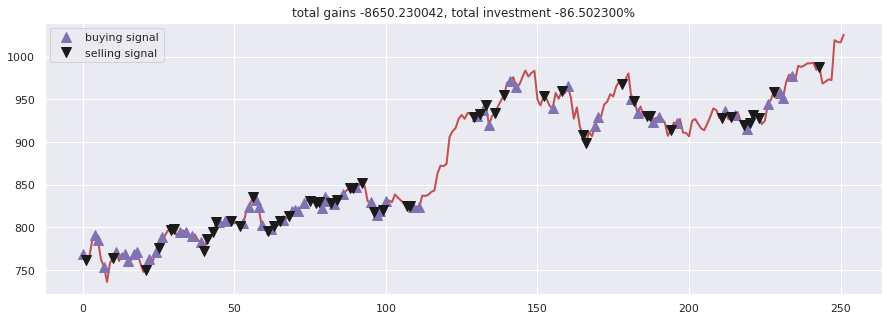

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()